In [2]:
"""Script to plot a learning rate scheduler"""

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.optim import SGD

from src.config.training_config import OptimizationConfig, TrainingConfig
from src.training.utils.initialization import initialize_lr_scheduler

MAX_STEPS = 30_000
LR_WARMUP_STEPS = 2_000
RESTART_WARMUP_STEPS = 100
RELORA_RESET_FREQ = 2_000

# Set the style for seaborn
sns.set_theme(font_scale=1.8, rc={"axes.grid": "True", "axes.grid.which": "both"})

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join([r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}"]),
}
matplotlib.rcParams.update(rc_fonts)

[2025-05-22 18:03:18,444] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to mps (auto detect)


W0522 18:03:18.777000 77495 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
wandb: WARNING This integration is tested and supported for lightning Fabric 2.1.3.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `lightning-fabric`.


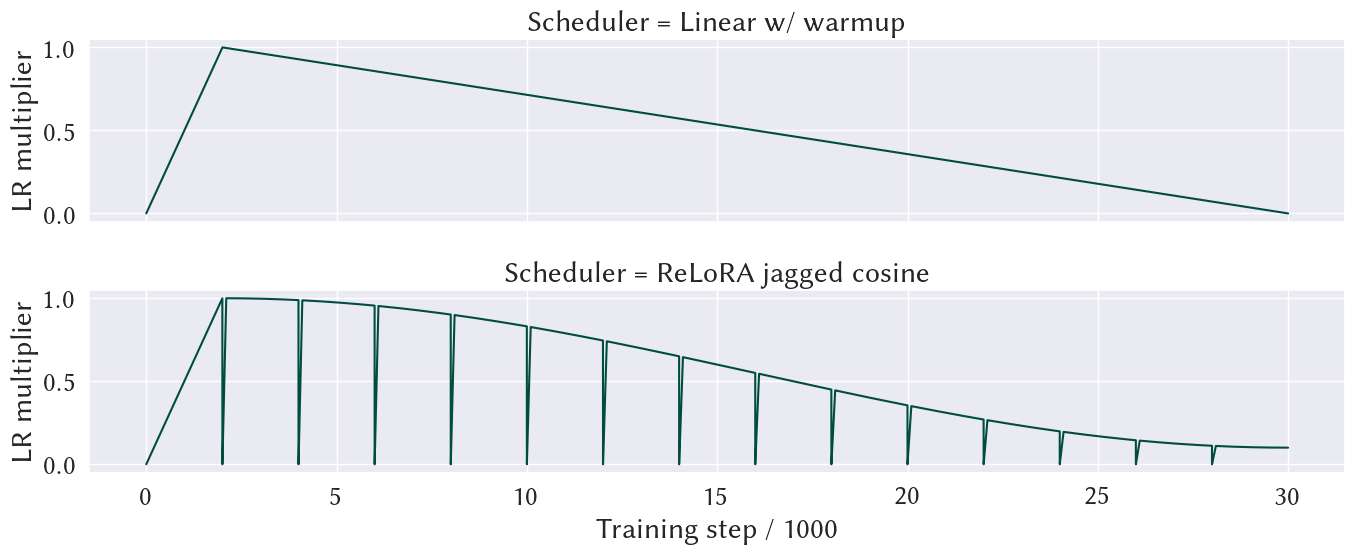

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharey=True)
steps = np.arange(MAX_STEPS)

# Plot linear warmup scheduler
optimizer1 = SGD([torch.tensor(1)], lr=1)
config1 = TrainingConfig(
    None,
    OptimizationConfig(
        lr=1,
        lr_scheduler="linear_with_warmup",
        lr_warmup_steps=LR_WARMUP_STEPS,
        restart_warmup_steps=RESTART_WARMUP_STEPS,
        min_lr_ratio=0.1,
    ),
    max_steps=MAX_STEPS,
)
config1.relora_reset_freq = RELORA_RESET_FREQ
scheduler1 = initialize_lr_scheduler(config1, optimizer1)

lrs1 = []
for _ in range(MAX_STEPS):
    optimizer1.step()
    lrs1.append(scheduler1.get_last_lr()[0])
    scheduler1.step()

# Plot ReLoRA scheduler
optimizer2 = SGD([torch.tensor(1)], lr=1)
config2 = TrainingConfig(
    None,
    OptimizationConfig(
        lr=1,
        lr_scheduler="relora_jagged_cosine",
        lr_warmup_steps=LR_WARMUP_STEPS,
        restart_warmup_steps=RESTART_WARMUP_STEPS,
        min_lr_ratio=0.1,
    ),
    max_steps=MAX_STEPS,
)
config2.relora_reset_freq = RELORA_RESET_FREQ
scheduler2 = initialize_lr_scheduler(config2, optimizer2)

lrs2 = []
for _ in range(MAX_STEPS):
    optimizer2.step()
    lrs2.append(scheduler2.get_last_lr()[0])
    scheduler2.step()

colour = "#004D40"
# Create seaborn line plots with custom colors
sns.lineplot(x=steps, y=lrs1, ax=ax1, color=colour, label="Linear warmup", legend=False)
sns.lineplot(x=steps, y=lrs2, ax=ax2, color=colour, label="ReLoRA jagged cosine", legend=False)

ax1.set_title("Scheduler = Linear w/ warmup")
ax2.set_title("Scheduler = ReLoRA jagged cosine")

plt.xlabel("Training step / 1000")
ax1.set_xticklabels([])
y_title = "LR multiplier"
ax1.set_ylabel(y_title)
ax2.set_ylabel(y_title)
ax2.set_xticks(range(0, 30_001, 5_000))
ax2.set_xticklabels([int(x / 1000) for x in ax2.get_xticks()])

# Adjust layout and save
fig.tight_layout()
fig.savefig("../graphs/lr-schedulers.pdf", bbox_inches="tight")
plt.show()